In [13]:
import mfem.ser as mfem
import numpy as np

In [ ]:
# Class example/review

class Pablo():
    def __init__(self, age, heigh, weight):
        self.name = 'Pablo'
        self.age = age
        self.heigh = heigh
        self.weight = weight

    def say_hi(self):
        print(f'Hi, my name is {self.name}')

pablo = Pablo(25, 170, 85)
pablo.say_hi()


# Solving the BVP

$$
\begin{cases}
-\Delta u = 1 & x \in \Omega = [0,1]\times[0,1] \\
u = 0 & x \in \partial \Omega
\end{cases}
$$

In [15]:
# create sample mesh for square shape
mesh = mfem.Mesh(10, 10, "TRIANGLE")

In [16]:
# create finite element function space
fec = mfem.H1_FECollection(1, mesh.Dimension())   # H1 - V 
fespace = mfem.FiniteElementSpace(mesh, fec) # Vh

In [17]:
# Retrieve dirichlet boundary DOFs 
ess_tdof_list = mfem.intArray()
ess_bdr = mfem.intArray([1]*mesh.bdr_attributes.Size())
fespace.GetEssentialTrueDofs(ess_bdr, ess_tdof_list)

In [18]:
#ess_bdr.ToList(), ess_tdof_list.ToList()

In [19]:
# constant coefficient (diffusion coefficient and RHS)
alpha = mfem.ConstantCoefficient(1.0)
f = mfem.ConstantCoefficient(1.0)

$$
\text{DiffusionIntegrator} = \nabla \cdot ( \alpha(x) \nabla u) 
$$


In [20]:
# define Bilinear and Linear operator
a = mfem.BilinearForm(fespace)
a.AddDomainIntegrator(mfem.DiffusionIntegrator(alpha))
a.Assemble()

b = mfem.LinearForm(fespace)
b.AddDomainIntegrator(mfem.DomainLFIntegrator(f))
b.Assemble()

In [21]:
# create gridfunction, which is where the solution vector is stored
x = mfem.GridFunction(fespace);
x.Assign(0.0)

<mfem._ser.gridfunc.GridFunction; proxy of <Swig Object of type 'mfem::GridFunction *' at 0x7301440fe370> >

In [22]:
# form linear equation (AX=B)
A = mfem.OperatorPtr()
B = mfem.Vector()
X = mfem.Vector()
a.FormLinearSystem(ess_tdof_list, x, b, A, X, B);
print("Size of linear system: " + str(A.Height()))

Size of linear system: 121


In [23]:
A.NumRows(), A.NumCols()

(121, 121)

In [24]:
# solve it using PCG solver and store the solution to x
AA = mfem.OperatorHandle2SparseMatrix(A)
M = mfem.GSSmoother(AA)
mfem.PCG(AA, M, B, X, 1, 200, 1e-12, 0.0)
a.RecoverFEMSolution(X, b, x)

   Iteration :   0  (B r, r) = 0.00663539
   Iteration :   1  (B r, r) = 0.00371547
   Iteration :   2  (B r, r) = 0.000455545
   Iteration :   3  (B r, r) = 1.36394e-05
   Iteration :   4  (B r, r) = 4.13047e-07
   Iteration :   5  (B r, r) = 2.24933e-08
   Iteration :   6  (B r, r) = 6.42285e-10
   Iteration :   7  (B r, r) = 3.89967e-11
   Iteration :   8  (B r, r) = 5.72023e-12
   Iteration :   9  (B r, r) = 1.02049e-13
   Iteration :  10  (B r, r) = 3.54358e-16
Average reduction factor = 0.21696


In [25]:
# extract vertices and solution as numpy array
verts = mesh.GetVertexArray()
sol = x.GetDataArray()

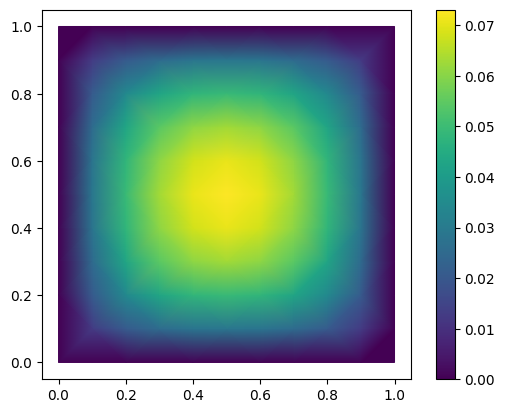

In [26]:
# plot solution using Matplotlib

import matplotlib.pyplot as plt
import matplotlib.tri as tri

triang = tri.Triangulation(np.array(verts)[:,0], np.array(verts)[:,1])

fig1, ax1 = plt.subplots()
ax1.set_aspect('equal')
tpc = ax1.tripcolor(triang, sol, shading='gouraud')
fig1.colorbar(tpc)
plt.show()

# Testing convergence

$$
\begin{cases}
-\Delta u = 2 \pi^2 \sin(\pi x) \sin(\pi y) & x \in \Omega = [0,1]\times[0,1] \\
u = 0 & x \in \partial \Omega
\end{cases}
$$

exact solution $u = \sin(\pi x) \sin(\pi y)$, you can also calculate $\nabla u = (\pi \cos(\pi x) \sin(\pi y), \pi \sin(\pi x) \cos(\pi y))^T$

Refinement level 0: h = 0.071, L2 error = 1.363e-02, H1 error = 3.470e-01
Refinement level 1: h = 0.035, L2 error = 3.448e-03, H1 error = 1.742e-01
Refinement level 2: h = 0.018, L2 error = 8.647e-04, H1 error = 8.720e-02
Refinement level 3: h = 0.009, L2 error = 2.163e-04, H1 error = 4.361e-02
Refinement level 4: h = 0.004, L2 error = 5.409e-05, H1 error = 2.181e-02


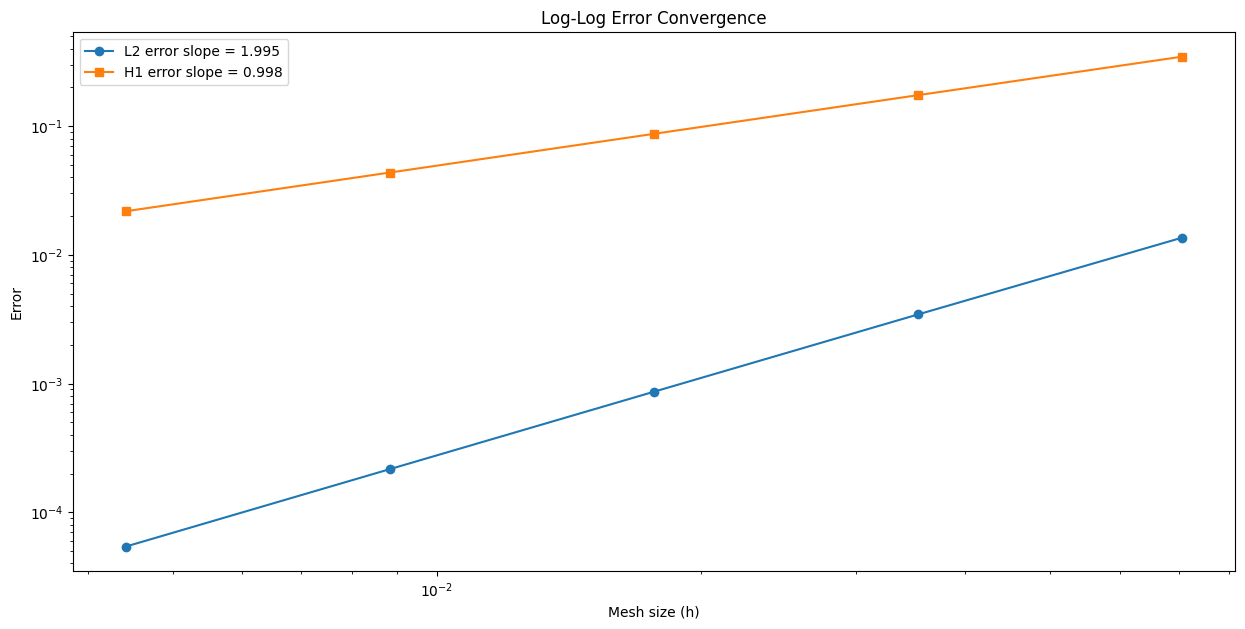

In [27]:
import mfem.ser as mfem
import numpy as np
import matplotlib.pyplot as plt

# Define the exact solution u = sin(pi*x) * sin(pi*y)
class ExactSolution(mfem.PyCoefficient):
    def EvalValue(self, x):
        return np.sin(np.pi * x[0]) * np.sin(np.pi * x[1])

# Define the exact gradient (for H1 error calculation)
class ExactGradient(mfem.VectorPyCoefficient):
    def __init__(self):
        super().__init__(2)  # 2D gradient

    def EvalValue(self, x):
        grad = np.zeros(2)
        grad[0] = np.pi * np.cos(np.pi * x[0]) * np.sin(np.pi * x[1])  # du/dx
        grad[1] = np.pi * np.sin(np.pi * x[0]) * np.cos(np.pi * x[1])  # du/dy
        return grad

# Define the corresponding RHS f = 2*pi^2 * sin(pi*x) * sin(pi*y)
class RHS(mfem.PyCoefficient):
    def EvalValue(self, x):
        return 2 * np.pi**2 * np.sin(np.pi * x[0]) * np.sin(np.pi * x[1])

# Function to solve the problem and calculate errors
def solve_and_compute_errors(mesh):
    fec = mfem.H1_FECollection(1, mesh.Dimension())  # H1 order=1
    fespace = mfem.FiniteElementSpace(mesh, fec)

    ess_tdof_list = mfem.intArray()
    ess_bdr = mfem.intArray([1]*mesh.bdr_attributes.Size())
    fespace.GetEssentialTrueDofs(ess_bdr, ess_tdof_list)

    alpha = mfem.ConstantCoefficient(1.0)
    rhs = RHS()

    # Define Bilinear and Linear operator
    a = mfem.BilinearForm(fespace)
    a.AddDomainIntegrator(mfem.DiffusionIntegrator(alpha))
    a.Assemble()
    
    b = mfem.LinearForm(fespace)
    b.AddDomainIntegrator(mfem.DomainLFIntegrator(rhs))
    b.Assemble()

    # Define GridFunction for the solution
    x = mfem.GridFunction(fespace)
    x.Assign(0.0)

    # Form linear system (AX=B)
    A = mfem.OperatorPtr()
    B = mfem.Vector()
    X = mfem.Vector()
    a.FormLinearSystem(ess_tdof_list, x, b, A, X, B)

    # Solve the system using PCG solver
    AA = mfem.OperatorHandle2SparseMatrix(A)
    M = mfem.GSSmoother(AA)
    mfem.PCG(AA, M, B, X, 0, 200, 1e-12, 0.0)
    a.RecoverFEMSolution(X, b, x)

    # Calculate L2 and H1 errors
    exact_sol = ExactSolution()
    exact_grad = ExactGradient()
    
    l2_error = x.ComputeL2Error(exact_sol)
    h1_error = x.ComputeH1Error(exact_sol, exact_grad)

    return l2_error, h1_error

# Main loop over mesh refinements
l2_errors = []
h1_errors = []
mesh_sizes = []

for ref_level in range(5):
    # Create and refine the mesh
    mesh = mfem.Mesh(10, 10, "TRIANGLE")
    for i in range(ref_level):
        mesh.UniformRefinement()

    # Get mesh size (for convergence plot)
    h = 1.0 / np.sqrt(mesh.GetNE()) # THIS IS AN APPROX. CONSIDERING SQUARE ELEMENTS
    mesh_sizes.append(h)

    # Solve and compute errors
    l2_error, h1_error = solve_and_compute_errors(mesh)
    l2_errors.append(l2_error)
    h1_errors.append(h1_error)
    print(f"Refinement level {ref_level}: h = {h:.3f}, L2 error = {l2_error:.3e}, H1 error = {h1_error:.3e}")

# Plot log-log error convergence
slope_L2, _ = np.polyfit(np.log(np.array(mesh_sizes)), np.log(np.array(l2_errors)), 1)
slope_H1, _ = np.polyfit(np.log(np.array(mesh_sizes)), np.log(np.array(h1_errors)), 1)
plt.figure(figsize=(15,7))
plt.loglog(mesh_sizes, l2_errors, 'o-', label=f'L2 error slope = {round(slope_L2,3)}')
plt.loglog(mesh_sizes, h1_errors, 's-', label=f'H1 error slope = {round(slope_H1,3)}')
plt.xlabel('Mesh size (h)')
plt.ylabel('Error')
plt.legend()
plt.title('Log-Log Error Convergence')
plt.show()
